<a href="https://colab.research.google.com/github/giovannalinodev/machine_learning/blob/main/gerenciamento_estoque.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gestão de Estoque com Aprendizado por Reforço

Neste projeto, utilizei **Aprendizado por Reforço** para treinar um agente que gerencia o estoque de uma loja. O objetivo do agente é aprender a tomar decisões sobre **reabastecimento de estoque** com base na **demanda dos produtos**, visando maximizar o **lucro** e minimizar **perdas** por **falta de estoque** ou **excesso de estoque**.

## 1. Instalação das Bibliotecas

Primeiro, instalei as bibliotecas necessárias para trabalhar com Aprendizado por Reforço:

- **Gym**: Para criar e simular o ambiente no qual o agente irá interagir.
- **Stable-Baselines3**: Para usar algoritmos de aprendizado por reforço como PPO e DQN.
- **Matplotlib**: Para visualização dos resultados do treinamento, como as recompensas ao longo do tempo.

```python
!pip install gym stable-baselines3[extra] matplotlib


In [1]:
pip install gym stable-baselines3[extra] matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
pip install 'shimmy>=2.0'


In [6]:
import gym
from gym import spaces
import numpy as np

class InventoryEnv(gym.Env):
    def __init__(self, max_stock=100, max_order=50):
        super(InventoryEnv, self).__init__()

        # Parâmetros do ambiente
        self.max_stock = max_stock  # Estoque máximo
        self.max_order = max_order  # Quantidade máxima que pode ser comprada

        # Ação do agente: quantidades de produtos que ele decide comprar
        self.action_space = spaces.Discrete(self.max_order + 1)  # Ações de 0 a max_order

        # Observação do ambiente: [estoque, demanda]
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([self.max_stock, 100]), dtype=np.float32)

        # Estado inicial: [estoque, demanda]
        self.state = np.array([50, 10])  # [estoque inicial, demanda inicial]

        # Custos (exemplo)
        self.cost_per_unit = 5  # Custo de comprar um produto
        self.storage_cost_per_unit = 1  # Custo de manter o estoque
        self.missing_cost = 10  # Custo de perder uma venda por falta de estoque

    def reset(self):
        # Resetando o estado para o início, mas sem redefinir o estoque
        self.state = np.array([50, 10])  # [estoque, demanda]
        return self.state

    def step(self, action):
        # Ação: quantidades que o agente decide comprar
        order_quantity = action

        # Atualizando o estoque: adicionando a quantidade pedida
        stock = self.state[0] + order_quantity

        # Garantindo que o estoque não ultrapasse o máximo
        stock = min(stock, self.max_stock)

        # Simulando a demanda (pode ser um valor fixo ou aleatório)
        demand = np.random.randint(0, 20)  # Demanda aleatória entre 0 e 20
        self.state = np.array([stock, demand])

        # Calculando o lucro e penalidades
        sales = min(stock, demand)  # O agente pode vender no máximo o que tem em estoque
        revenue = sales * 10  # Preço de venda de cada unidade
        cost = order_quantity * self.cost_per_unit + stock * self.storage_cost_per_unit
        missing_sales = max(0, demand - stock) * self.missing_cost

        # Recompensa: lucro líquido
        reward = revenue - cost - missing_sales

        # Definindo a condição de término do episódio: podemos usar uma condição simples como número de interações
        done = False
        if self.state[0] == 0 or self.state[0] == self.max_stock:  # Fim do episódio se o estoque esgotar ou atingir o máximo
            done = True

        return self.state, reward, done, {}

    def render(self):
        # Visualizando o estado atual
        print(f"Estoque: {self.state[0]}, Demanda: {self.state[1]}")


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.43     |
|    ep_rew_mean     | -323     |
| time/              |          |
|    fps             | 1137     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.88        |
|    ep_rew_mean          | -306        |
| time/                   |             |
|    fps                  | 774         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016789366 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss   

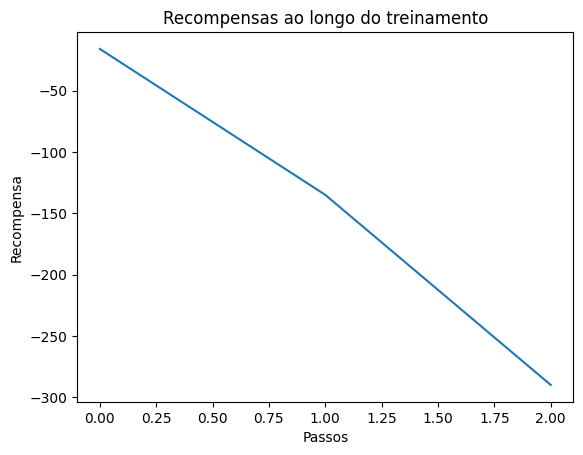

In [7]:
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Criando o ambiente
env = InventoryEnv()

# Criando o modelo PPO
model = PPO("MlpPolicy", env, verbose=1)

# Treinando o modelo
model.learn(total_timesteps=10000)

# Testando o modelo treinado
obs = env.reset()
done = False
rewards = []

# Jogando uma rodada com o agente treinado
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    env.render()  # Exibindo o ambiente

# Exibindo as recompensas obtidas pelo modelo
print(f"Recompensas totais: {sum(rewards)}")

# Plotando as recompensas ao longo do tempo
plt.plot(rewards)
plt.xlabel('Passos')
plt.ylabel('Recompensa')
plt.title('Recompensas ao longo do treinamento')
plt.show()


## Não foi utilizada uma base de dados tradicional

Embora a tarefa tenha mencionado o uso de uma **base de dados** para treinar os modelos, neste projeto, não utilizei uma base de dados tradicional (como um arquivo CSV ou SQL). Em vez disso, criei um **ambiente de simulação** para o **aprendizado por reforço**, que serve como a "base de dados" para o agente.

No **aprendizado por reforço**, o agente aprende interagindo com o ambiente, tomando ações, observando as consequências dessas ações e recebendo recompensas. Este processo é fundamental para a aprendizagem e não depende diretamente de uma base de dados de exemplos históricos ou tabelas de dados.

   - O ambiente de **gestão de estoque** foi criado com base em um modelo simples, onde o agente toma decisões sobre quando **comprar** e **vender** produtos.
   - A base de dados nesse caso é **o próprio ambiente** que gera a **demanda** e a **atualização de estoque** de forma dinâmica. O agente interage diretamente com o ambiente para aprender as melhores estratégias.
   
   - Em vez de aprender com dados passados (como faria um modelo supervisionado), a ideia seria que o agente aprende ao executar ações e observar os resultados dessas ações (recompensas). O **ambiente de estoque** fornece feedback imediato sobre as decisões do agente.
   - A base de dados no aprendizado por reforço é, portanto, **gerada em tempo real** pelo próprio agente enquanto ele interage com o ambiente. Ou seja, não haveria um dataset pré-existente.
   

